In [1]:
import pandas as pd
import numpy as np
!pip install langdetect
import langdetect

In [2]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('/content/drive/MyDrive/datatraine/train.csv')

In [4]:
data

id  ... loathe
0       0000997932d777bf  ...      0
1       000103f0d9cfb60f  ...      0
2       000113f07ec002fd  ...      0
3       0001b41b1c6bb37e  ...      0
4       0001d958c54c6e35  ...      0
...                  ...  ...    ...
159566  ffe987279560d7ff  ...      0
159567  ffea4adeee384e90  ...      0
159568  ffee36eab5c267c9  ...      0
159569  fff125370e4aaaf3  ...      0
159570  fff46fc426af1f9a  ...      0

[159571 rows x 8 columns]

In [5]:
data.drop('id',axis=1,inplace=True)

I am dropping this columns because it si not useful in this case

# Creating Labels 

In [6]:
label_col=list(data.columns[1:])
def get_labels(rows):
  val=np.where(rows==1)[0]
  if len(val)==0:
    return "Normal"
  return ",".join([label_col[x] for x in val])
labels=data[label_col].apply(lambda x:get_labels(x),axis=1)

**Now there i have converted all the labels into one like if i have a comment that have some sentiments like malignant & highly_malignant & rude so it will show me malignant,highly_malignant,rude so with the help of this i can easily understand which comment contains how many sentiments and there is one disadvantage of this we might have many labels but the advantage is we will create a more generalized model**

---



In [7]:
data['Labels']=labels

# Cleaning Text

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
wnl=WordNetLemmatizer()
corpus=[]

In [10]:
for i in range(len(data)):
  review=re.sub('[^a-zA-Z]',' ',data['comment_text'][i])
  review=review.lower()
  review=review.split()
  review=[wnl.lemmatize(word) for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  corpus.append(review)

**Here i am removing all the extra text that is not useful for my model**

In [11]:
data['clean_comment_text']=corpus

# Feature Engineering

In [12]:
data['Language']=data['clean_comment_text'].apply(lambda x: langdetect.detect(x) if x.strip() !="" else "")
data

comment_text  ...  Language
0       Explanation\nWhy the edits made under my usern...  ...        en
1       D'aww! He matches this background colour I'm s...  ...        en
2       Hey man, I'm really not trying to edit war. It...  ...        en
3       "\nMore\nI can't make any real suggestions on ...  ...        en
4       You, sir, are my hero. Any chance you remember...  ...        en
...                                                   ...  ...       ...
159566  ":::::And for the second time of asking, when ...  ...        en
159567  You should be ashamed of yourself \n\nThat is ...  ...        en
159568  Spitzer \n\nUmm, theres no actual article for ...  ...        en
159569  And it looks like it was actually you who put ...  ...        en
159570  "\nAnd ... I really don't think you understand...  ...        en

[159571 rows x 10 columns]

**Here i am adding more columns that will tell me which comment has which language like ENGLISH,HINDI E.T.C**

In [13]:
data['word_count']=data['clean_comment_text'].apply(lambda x:len(str(x).split(" ")))
data['char_count']=data['clean_comment_text'].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
data['sentence_count']=data['clean_comment_text'].apply(lambda x: len(str(x).split(".")))
data['average_word_length']=data['char_count']/data['word_count']
data['avg_sentence_length']=data['word_count']/data['sentence_count']

*Here i am doing more feature engineering which will tell me the average word lenth and avg sentence length will will help me to understand what average len of comment people do*

In [14]:
def find_pol(review):
  return TextBlob(review).sentiment.polarity

inding the positive or negative sentiment with the help of TEXTBLOB

In [15]:
data['Sentiment']=data['clean_comment_text'].apply(find_pol)

In [16]:
def labels(review):
  if review>0:
    return 'positive'

  elif review<0:
    return 'negative'
  elif review==0:
    return 'neutral'

Converting the sentiment values using this functions into positive, negative and neutral

In [17]:
data['Sentiment_Label']=data['Sentiment'].apply(labels)
data.head()

comment_text  ...  Sentiment_Label
0  Explanation\nWhy the edits made under my usern...  ...         positive
1  D'aww! He matches this background colour I'm s...  ...         positive
2  Hey man, I'm really not trying to edit war. It...  ...         positive
3  "\nMore\nI can't make any real suggestions on ...  ...         positive
4  You, sir, are my hero. Any chance you remember...  ...          neutral

[5 rows x 17 columns]

In [18]:
df=data[['malignant','highly_malignant','rude','threat','abuse','loathe']]

In [19]:
counts=df.sum()
counts

malignant           15294
highly_malignant     1595
rude                 8449
threat                478
abuse                7877
loathe               1405
dtype: int64

# EDA

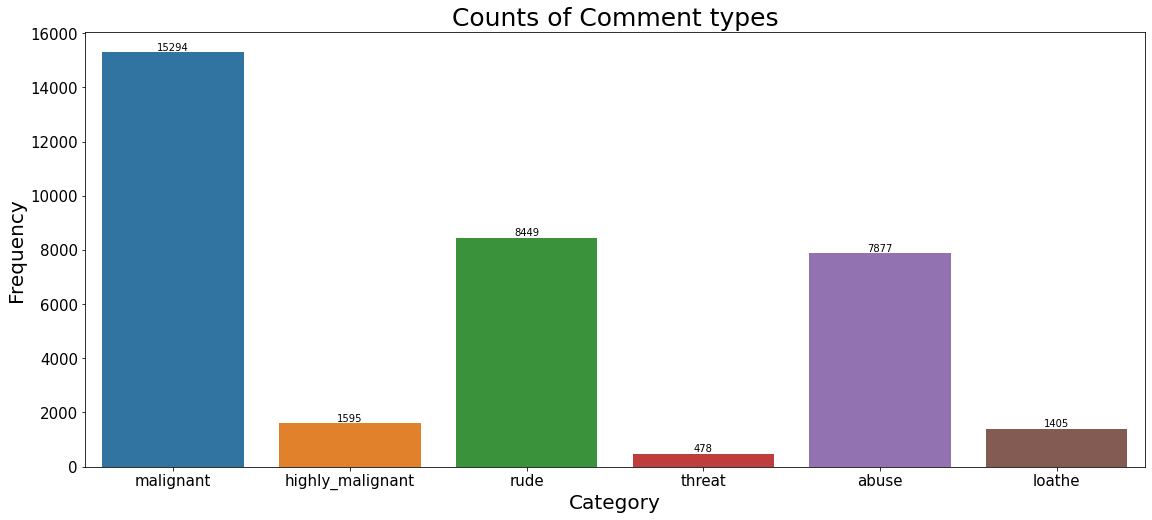

In [20]:
plt.figure(figsize=(19,8))
ax=sns.barplot(counts.index,counts.values)
plt.title("Counts of Comment types",fontsize=25)
plt.ylabel("Frequency",fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel("Category",fontsize=20)
plt.xticks(fontsize=15)
rects=ax.patches
labels=counts.values
for rect,label in zip(rects,labels):
  height=rect.get_height()
  ax.text(rect.get_x()+ rect.get_width()/2,height+5,label,ha='center',va='bottom')
plt.show()

Malignant,Rude and Abuse are highly comments that peoples do and there are less values of highly_malignant and threat and loathe as compare to upper three

(array([     0.,  20000.,  40000.,  60000.,  80000., 100000., 120000.,
        140000., 160000.]),
 <a list of 9 Text major ticklabel objects>)

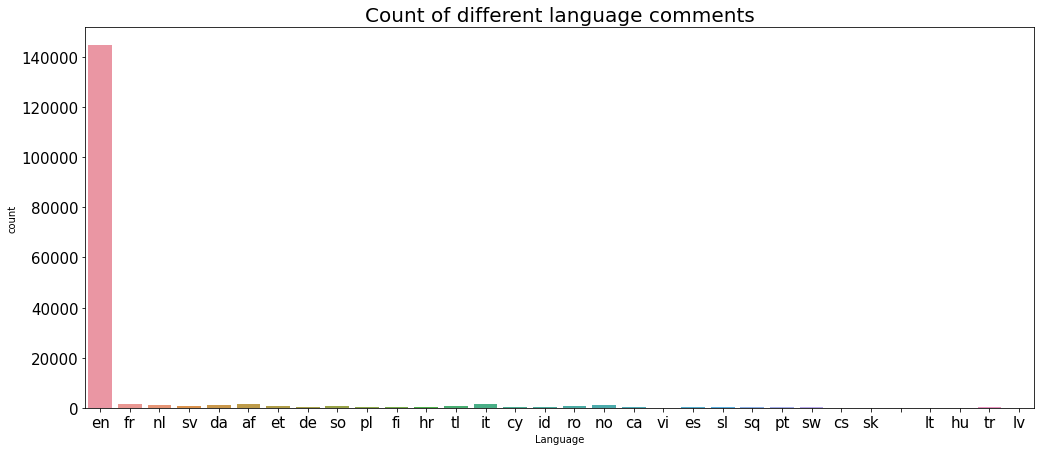

In [21]:
plt.figure(figsize=(17,7))
sns.countplot(data['Language'])
plt.title("Count of different language comments",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

as i can see there are many comments that are only in english and others are in different language so i can filter them out beacuse these have very less count my model will face tille difficulty to understand other languages with this much of less count or i can even do text augmentation but these rows are already have a high count so my system will not able to train the model

In [22]:
data['Sentiment_Label'].value_counts()

positive    83013
neutral     40841
negative    35717
Name: Sentiment_Label, dtype: int64

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000., 90000.]),
 <a list of 10 Text major ticklabel objects>)

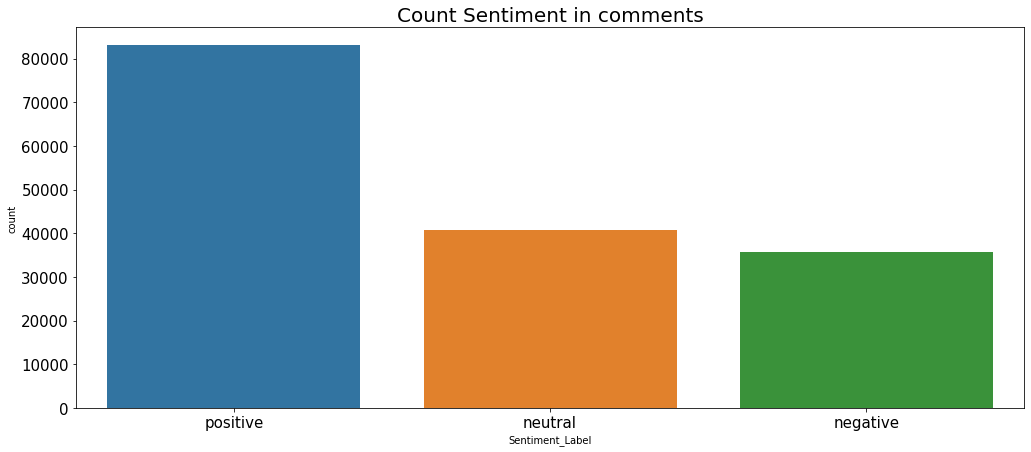

In [23]:
plt.figure(figsize=(17,7))
sns.countplot(data['Sentiment_Label'])
plt.title("Count Sentiment in comments",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

As we can see there are many comments that are positive and neagtive also have acount of 35717 so i can say mostly people are happy and some are facing some problem that why neutral sentiment is there and many people are not really happy that our neagtive sentiment shows

Text(0.5, 1.0, 'Average Sentence Length')

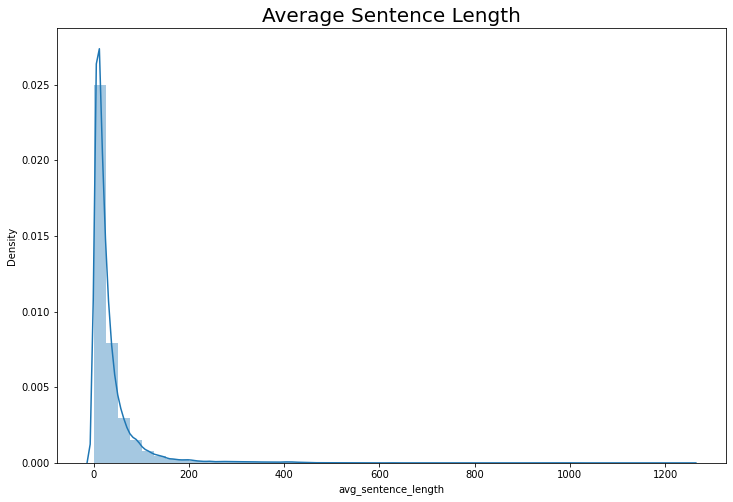

In [24]:
plt.figure(figsize=(12,8))
sns.distplot(data['avg_sentence_length'])
plt.title("Average Sentence Length",fontsize=20)


The average legth of comment lies between 0-50 and there are also many peoples who use to do long comments like 1200 long also

Text(0.5, 1.0, 'Average Word Length')

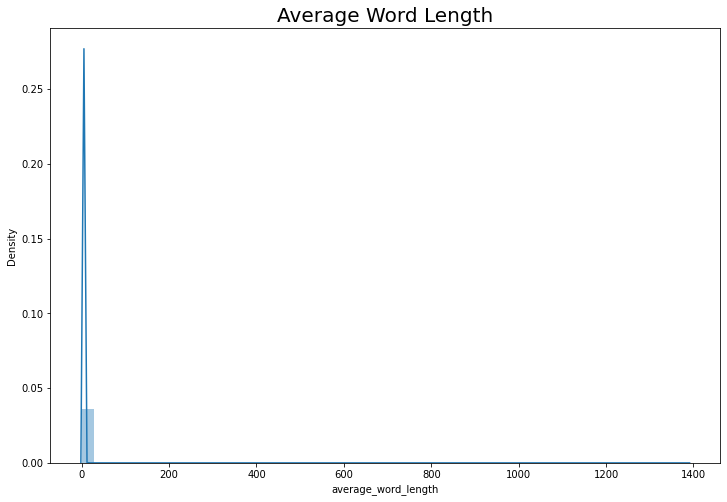

In [25]:
plt.figure(figsize=(12,8))
sns.distplot(data['average_word_length'])
plt.title("Average Word Length",fontsize=20)

The average word length of most of the comments is between 0-20

In [26]:
data['Labels'].value_counts()

Normal                                                 143346
malignant                                                5666
malignant,rude,abuse                                     3800
malignant,rude                                           1758
malignant,abuse                                          1215
malignant,highly_malignant,rude,abuse                     989
malignant,rude,abuse,loathe                               618
rude                                                      317
abuse                                                     301
malignant,highly_malignant,rude,abuse,loathe              265
rude,abuse                                                181
malignant,highly_malignant,rude                           158
malignant,loathe                                          136
malignant,abuse,loathe                                    134
malignant,rude,threat,abuse                               131
malignant,threat                                          113
malignan

# Labels with counts

Text(0, 0.5, 'Labels')

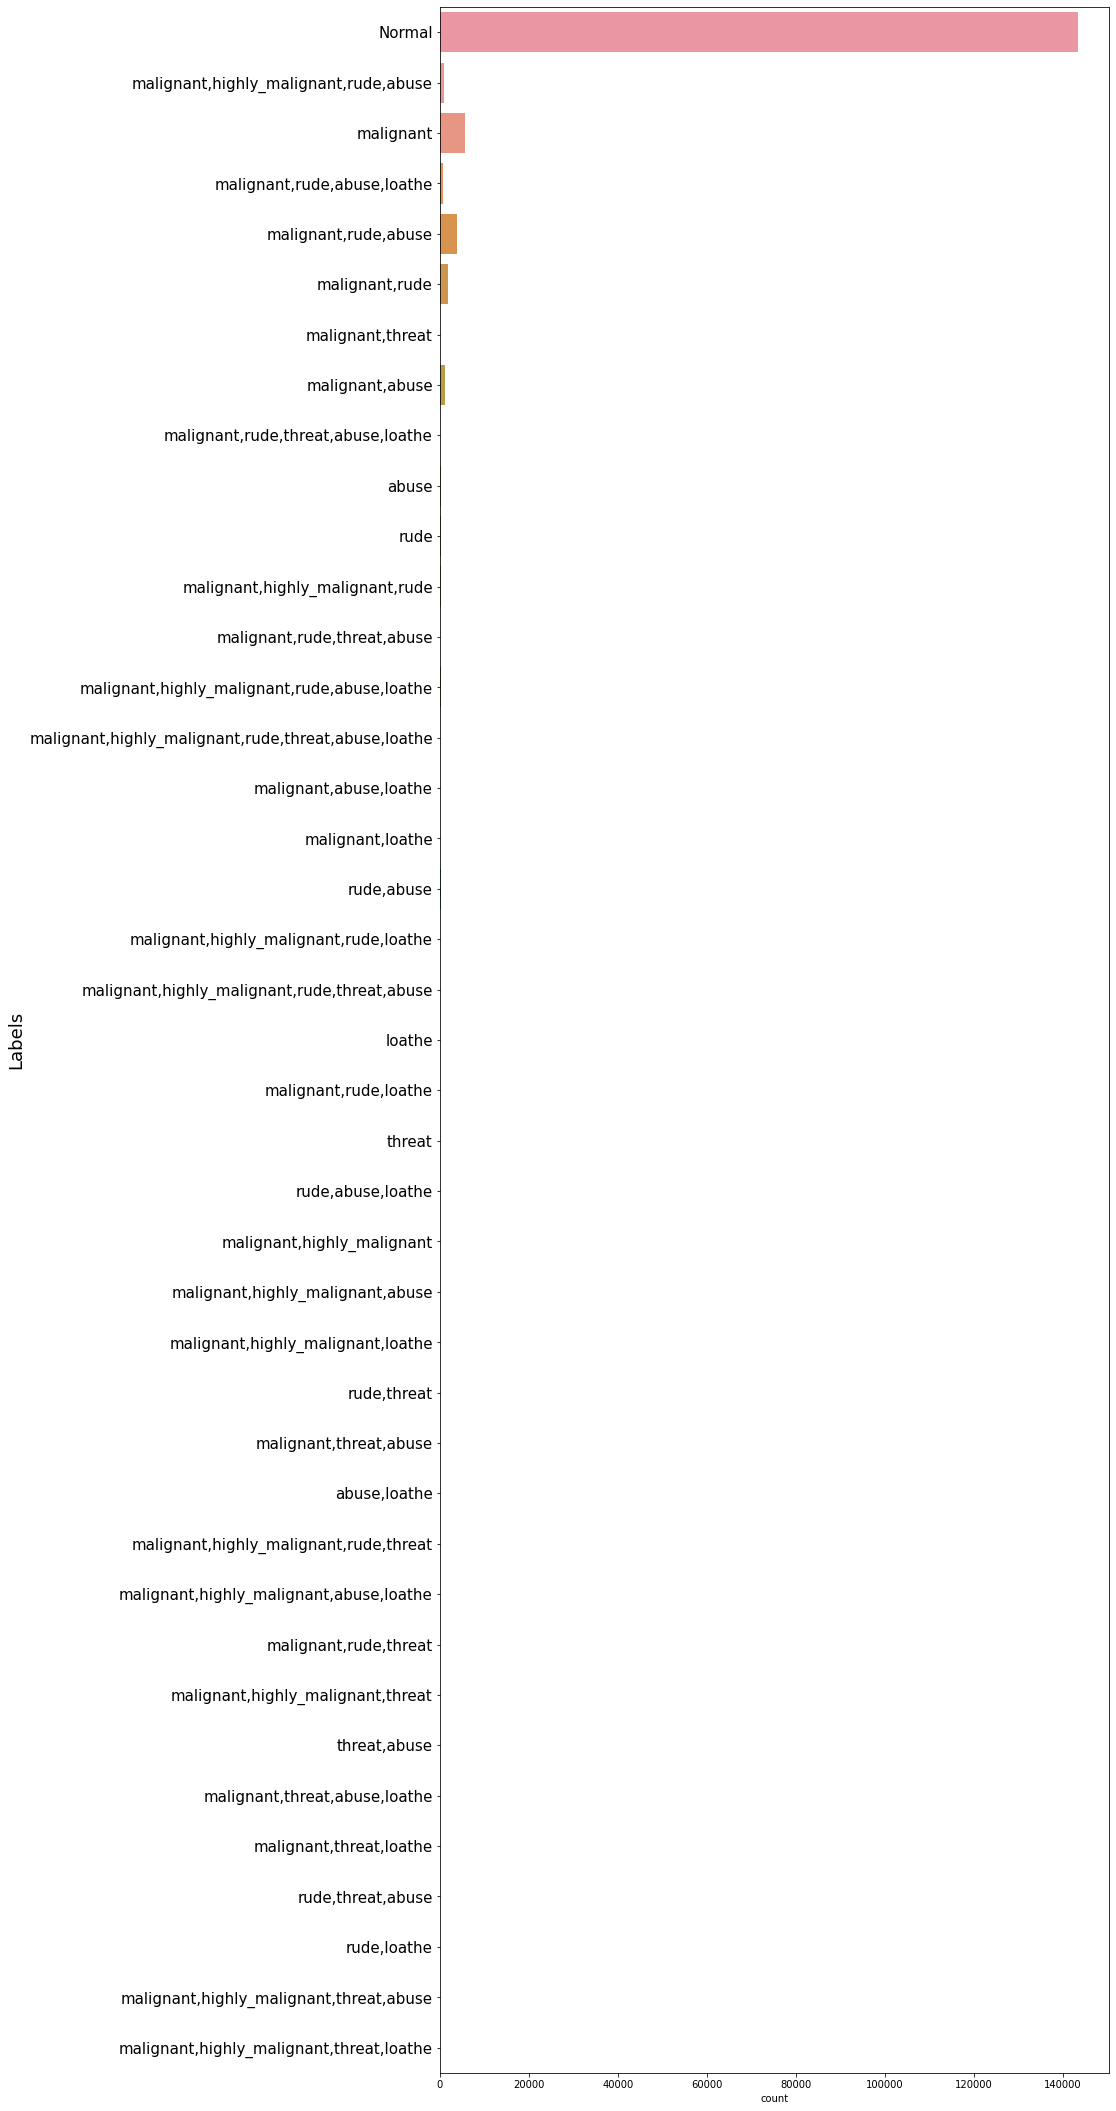

In [49]:
plt.figure(figsize=(12,38))
sns.countplot(data=data,
              y='Labels')
plt.yticks(fontsize=15)
plt.ylabel("Labels",fontsize=18)

with the above graph i can see which comment type is having more count 

# words from Normal comment

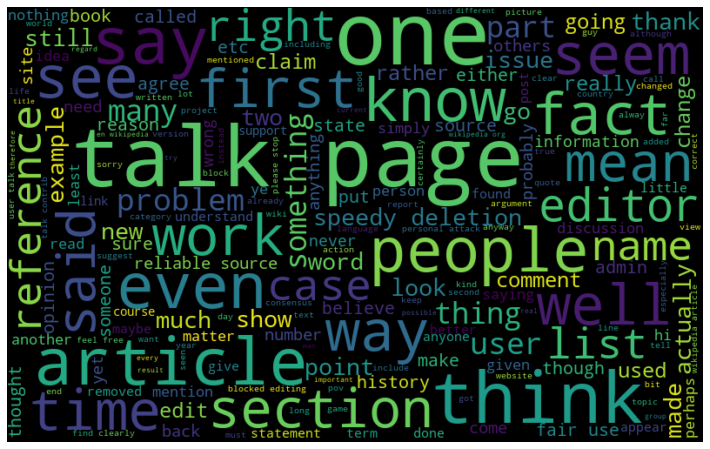

In [28]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='Normal']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Some words from Malignant comment

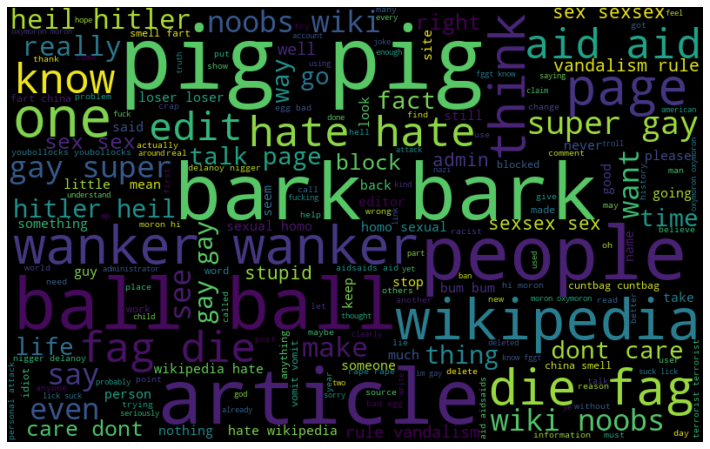

In [29]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Words from malignant,rude,abuse comment

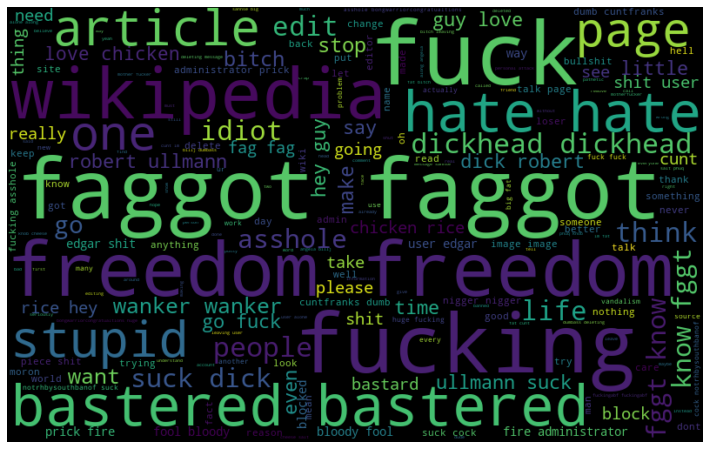

In [30]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,rude,abuse']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word from Malignant,rude comment

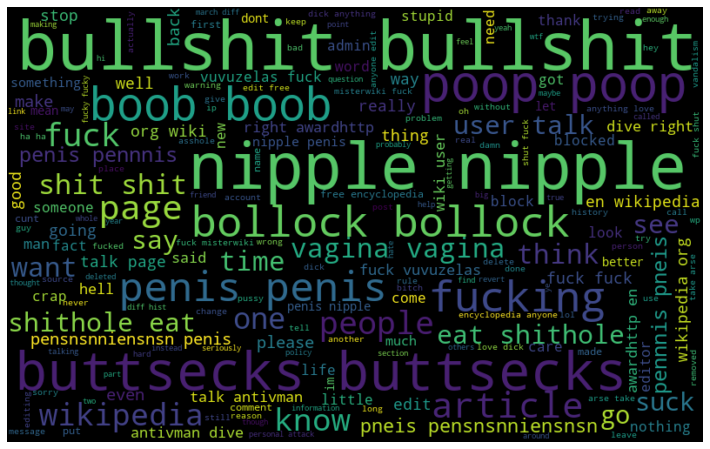

In [31]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,rude']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word from malignant,abuse comment

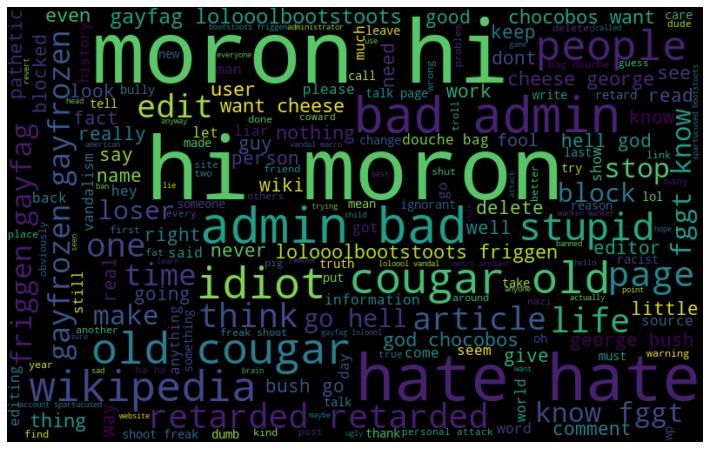

In [32]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,abuse']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Words from malignant,highly_malignant,rude,abuse comment

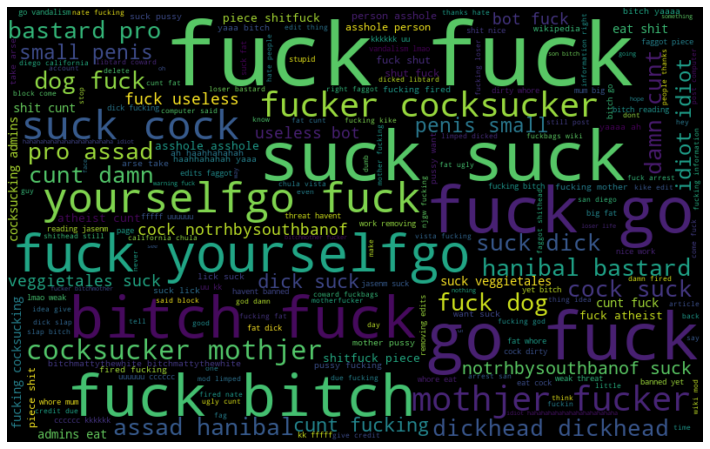

In [33]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,highly_malignant,rude,abuse']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word from malignant,rude,abuse,loathe comments

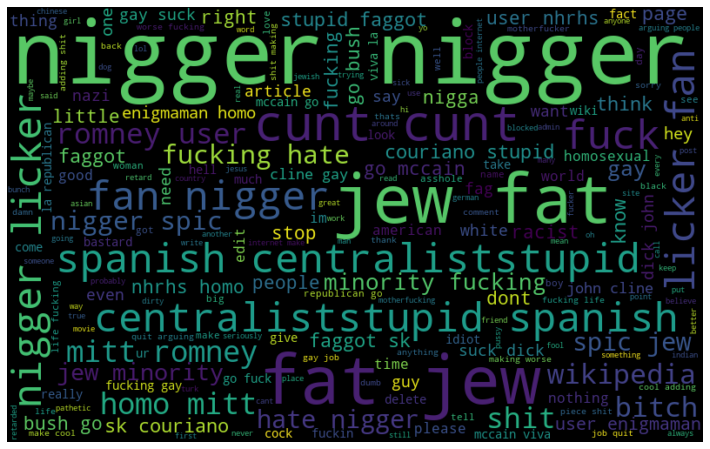

In [34]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,rude,abuse,loathe']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Words for rude in comment

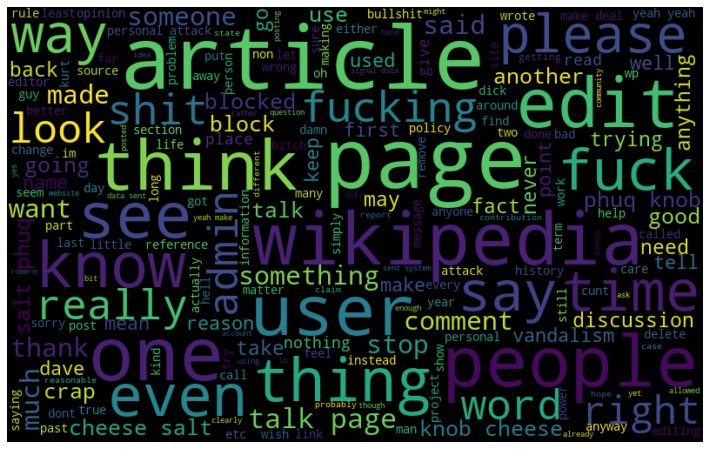

In [35]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='rude']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word for Abuse comments

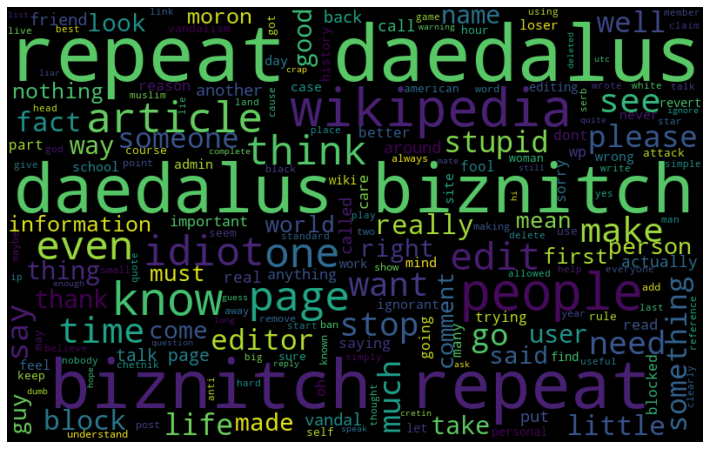

In [36]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='abuse']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word for malignant,highly_malignant,rude,abuse,loathe comment

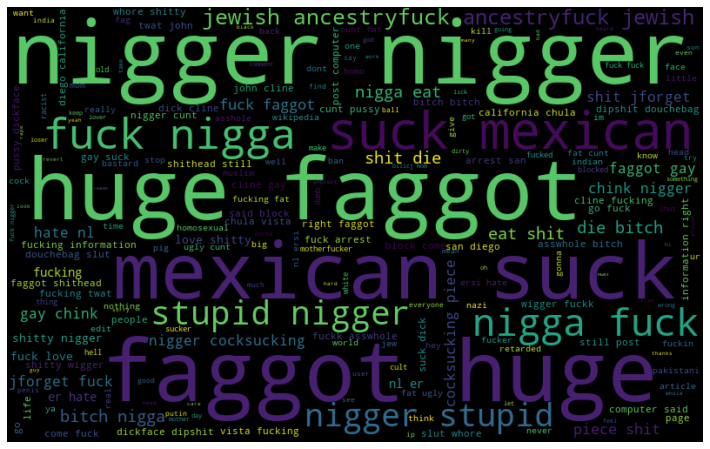

In [37]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,highly_malignant,rude,abuse,loathe']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# WOrd for rude,abuse comment

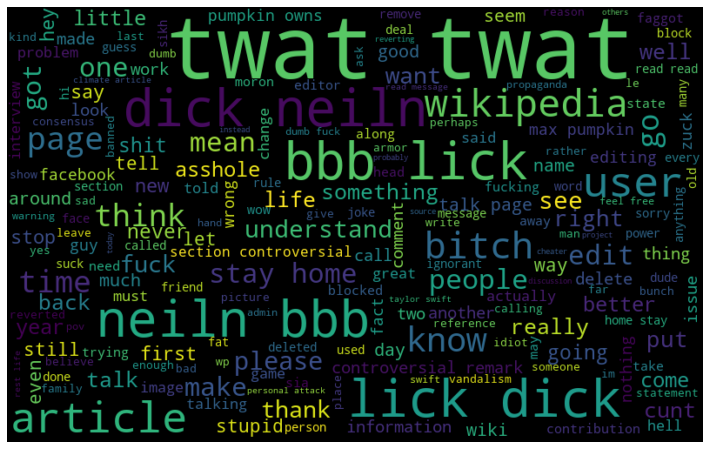

In [38]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='rude,abuse']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Word for malignant,highly_malignant,rude comment

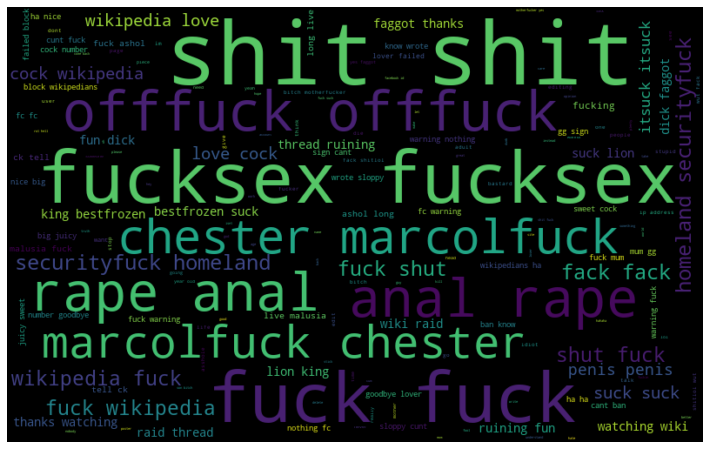

In [39]:
from wordcloud import WordCloud
all_words = " ".join([sentence for sentence in data['clean_comment_text'][data['Labels']=='malignant,highly_malignant,rude']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()